In [1]:
logger_name = "lstnet"

# Path appended in order to import from util
import sys
sys.path.append('..')
from util.model_util import LoadModel, SaveModel, SaveResults, SaveHistory
from util.Msglog import LogInit

from datetime import datetime

from lstnet_util import GetArguments, LSTNetInit
from pandas_util import DataUtil
from lstnet_model import PreSkipTrans, PostSkipTrans, PreARTrans, PostARTrans, LSTNetModel, ModelCompile
from lstnet_plot import AutoCorrelationPlot, PlotHistory, PlotPrediction

import tensorflow as tf
import argparse

import numpy as np
import matplotlib.pyplot as plt
import sklearn
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error
from math import sqrt


In [2]:
# Reading data
filename = 'data/bq_results_8_12_2020.csv'
trainpercent = 0.6
validpercent = 0.2
horizon=0
window=10
normalize=0
Data = DataUtil(filename,
                trainpercent,
                validpercent,
                horizon,
                window,
                normalise=normalize,
                dependent_variable="iperf_throughput_32_threads")


/home/derek/projects/ml/tf_src_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,14,20,77,78,79,80,81,82) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


21405.15192908794
8126.507909904192


In [3]:
val_performance = {}
performance = {}

In [4]:
#Root relative squared error
def tf_rse(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.sum(K.square(y_true - y_pred)))     
    #    RSE = -----------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)))       
    #
    #           K.sqrt(K.sum(K.square(y_true - y_pred))/(N-1))
    #        = ----------------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)/(N-1)))
    #
    #
    #           K.sqrt(K.mean(K.square(y_true - y_pred)))
    #        = ------------------------------------------
    #           K.std(y_true)
    #
    num = K.sqrt(K.mean(K.square(y_true - y_pred), axis=None))
    den = K.std(y_true, axis=None)
    
    return num / den

def rse_test1(y_true, y_pred):
    return K.square(y_true - y_pred)

def rse_test2(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred), axis=None))

def rse_test3(y_true, y_pred):
    return K.std(y_true, axis=None)

def rse(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.sum(K.square(y_true - y_pred)))     
    #    RSE = -----------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)))       
    #
    #           K.sqrt(K.sum(K.square( y_true - y_pred))/(N-1))
    #        = ----------------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)/(N-1)))
    #
    #
    #           K.sqrt(K.mean(K.square(y_true - y_pred)))
    #        = ------------------------------------------
    #           K.std(y_true)
    #
    num = np.sqrt(np.mean(np.square(y_true - y_pred), axis=None))
    den = np.std(y_true, axis=None)
    
    return num / den

def tf_corr(y_true, y_pred):
    #
    # This function calculates the correlation between the true and the predicted outputs
    #
    num1 = y_true - K.mean(y_true, axis=0)
    num2 = y_pred - K.mean(y_pred, axis=0)
    
    num  = K.mean(num1 * num2, axis=0)
    den  = K.std(y_true, axis=0) * K.std(y_pred, axis=0)
    
    return K.mean(num / den)

def corr(y_true, y_pred):
    #
    # This function calculates the correlation between the true and the predicted outputs
    #
    num1 = y_true - np.mean(y_true, axis=0)
    num2 = y_pred - np.mean(y_pred, axis=0)
    
    num  = np.mean(num1 * num2, axis=0)
    den  = np.std(y_true, axis=0) * np.std(y_pred, axis=0)
    
    return np.mean(num / den)

def single_rse(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.sum(K.square(y_true - y_pred)))     
    #    RSE = -----------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)))       
    #
    #           K.sqrt(K.sum(K.square(y_true - y_pred))/(N-1))
    #        = ----------------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)/(N-1)))
    #
    #
    #           K.sqrt(K.mean(K.square(y_true - y_pred)))
    #        = ------------------------------------------
    #           K.std(y_true)
    #
    num = K.sqrt(K.mean(K.square(y_true[:,0] - y_pred[:,0]), axis=None))
    den = K.std(y_true, axis=None)
    
    return num / den


def single_corr(y_true, y_pred):
    #
    # This function calculates the correlation between the true and the predicted outputs
    #
    num1 = y_true[:,0] - K.mean(y_true[:,0], axis=0)
    num2 = y_pred[:,0] - K.mean(y_pred[:,0], axis=0)
    
    num  = K.mean(num1 * num2, axis=0)
    den  = K.std(y_true[:,0], axis=0) * K.std(y_pred[:,0], axis=0)
    
    return K.mean(num / den)

In [5]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10,
                                                mode='min')

In [6]:
Data.train[0][:,:,0:2][0]

array([[-0.35502973, -0.6500241 ],
       [-0.20121212, -0.6500241 ],
       [-0.5488399 , -0.6500241 ],
       [-0.48042184, -0.6500241 ],
       [-0.5901861 , -0.6500241 ],
       [-0.21007203, -0.6500241 ],
       [ 0.02114661, -0.6500241 ],
       [ 0.04132748, -0.6500241 ],
       [-0.13230184, -0.6500241 ],
       [ 0.10913028, -0.6500241 ]], dtype=float32)

In [7]:
Data.train[1][:,0]

array([-0.7564322 ,  0.33075067, -0.0091247 , ...,  1.0063176 ,
        1.0079173 ,  1.0145622 ], dtype=float32)

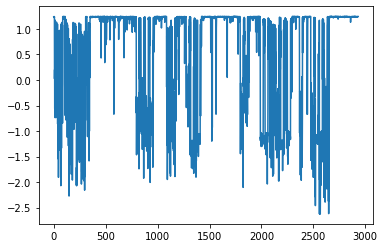

In [8]:
plt.plot(Data.test[1][:,0])

In [9]:
accuracy_stats = {}
accuracy_stats['rmse'] = {}
accuracy_stats['rse'] = {}
accuracy_stats['corr'] = {}
accuracy_stats['accuracy'] = {}
accuracy_stats['mae'] = {}
accuracy_stats['predicted'] = {}
accuracy_stats['mse'] = {}

## Simple MLP

Here we are testing the effectiveness of a simple ANN (MLP) on our dataset

In [67]:
linear = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(10,3)),
    tf.keras.layers.Dense(units=15),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=15),
    tf.keras.layers.Dense(units=1),
])

In [68]:
linear.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [69]:
Data.train[1][:,0].shape[0]

11586

In [70]:
linear.fit(Data.train[0][:,:,:], Data.train[1][:,0].reshape(Data.train[1][:,0].shape[0],1), epochs=100, validation_data=(Data.valid[0][:,:,:], Data.valid[1][:,0].reshape(Data.valid[1][:,0].shape[0],1)), callbacks=[early_stopping])

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5156 - tf_rse: 0.7104 - tf_corr: 0.7076 - mean_absolute_error: 0.4781 - mean_squared_error: 0.5156 - root_mean_squared_error: 0.7180 - val_loss: 0.3020 - val_tf_rse: 1.1730 - val_tf_corr: 0.6396 - val_mean_absolute_error: 0.3921 - val_mean_squared_error: 0.3020 - val_root_mean_squared_error: 0.5496
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.2899 - tf_rse: 0.5643 - tf_corr: 0.8268 - mean_absolute_error: 0.3698 - mean_squared_error: 0.2899 - root_mean_squared_error: 0.5384 - val_loss: 0.3023 - val_tf_rse: 1.2353 - val_tf_corr: 0.6392 - val_mean_absolute_error: 0.3969 - val_mean_squared_error: 0.3023 - val_root_mean_squared_error: 0.5498
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.2872 - tf_rse: 0.5599 - tf_corr: 0.8293 - mean_absolute_error: 0.3670 - mean_squared_error: 0.2872 - root_mean_squared_error: 0.5359 - val_loss: 0.3032 - val_tf_rse: 1.0

In [71]:
linear_stats = linear.evaluate(Data.test[0], Data.test[1][:,0].reshape(2933,1))
linear_stats

92/92 [==============================] - 0s 714us/step - loss: 0.2496 - tf_rse: 5.1666 - tf_corr: 0.3485 - mean_absolute_error: 0.2944 - mean_squared_error: 0.2496 - root_mean_squared_error: 0.4996


[0.2496393918991089,
 5.166591167449951,
 0.3484739363193512,
 0.29436376690864563,
 0.2496393918991089,
 0.49963927268981934]

In [72]:
linear_predicted = linear.predict(Data.test[0][:,:,:])

np.save('predicted_results/mlp_32_predicted.npy', linear_predicted)
np.savetxt('predicted_results/mlp_32_predicted.txt', linear_predicted)

In [16]:
np.sqrt(np.mean(np.square(linear_predicted - Data.test[1][:,0].reshape(2933,1)), axis=None))

0.49603721

In [17]:
linear_predicted.shape

(2933, 1)

In [18]:
dividend = np.sum(np.square(linear_predicted - Data.test[1][:,0].reshape(2933,1)))
dividend

721.67316

In [19]:
Data.test[1][:,0].reshape(2933,1)

array([[1.2386438],
       [1.2398742],
       [1.2398742],
       ...,
       [1.2412279],
       [1.241474 ],
       [1.2422123]], dtype=float32)

In [20]:
linear_predicted

array([[1.1790996],
       [1.1711307],
       [1.1914346],
       ...,
       [1.194761 ],
       [1.195249 ],
       [1.1948962]], dtype=float32)

In [21]:
sqrt(mean_squared_error(Data.test[1][:,0].reshape(2933,1), linear_predicted))

0.4960372021503706

In [22]:
rse(Data.test[1][:,0].reshape(2933,1), linear_predicted)

0.5026948

In [23]:
# dividend = np.sum(np.square(linear_predicted - Data.test[1][:,0].reshape(2933,1)))
# s = np.std(Data.test[1][:,0].reshape(2933,1))
# divisor = np.sum(np.square(t - Data.test[1][:,0].reshape(2933,1)))

# np.sqrt(dividend/divisor)

In [24]:
# t = (1.0/2933.0)*np.sum(Data.test[1][:,0].reshape(2933,1))
# t

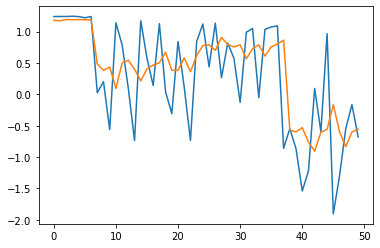

In [25]:
plt.plot(Data.test[1][0:50,0])
plt.plot(linear_predicted[0:50])
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(Data.test[1][:,0], linear_predicted.flatten())
rmse = sqrt(mean_squared_error(Data.test[1][:,0], linear_predicted.flatten()))
mae = mean_absolute_error(Data.test[1][:,0], linear_predicted.flatten())
rse_val = rse(Data.test[1][:,0], linear_predicted.flatten())

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')

accuracy_stats['rmse']['mlp'] = rmse
accuracy_stats['rse']['mlp'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['mlp'] = mae
accuracy_stats['predicted']['mlp'] = linear_predicted
accuracy_stats['mse']['mlp'] = mse

MSE: 0.24605290591716766
RMSE: 0.4960372021503706
MAE: 0.277376264333725
RSE: 0.5026947855949402


## SIMPLE LSTM

Here we run our data through a simple lstm for comparison

In [91]:
Data.train[0][:,:,0][0]

array([-0.35502973, -0.20121212, -0.5488399 , -0.48042184, -0.5901861 ,
       -0.21007203,  0.02114661,  0.04132748, -0.13230184,  0.10913028],
      dtype=float32)

In [92]:
Data.train[0][:,:,0][0]

array([-0.35502973, -0.20121212, -0.5488399 , -0.48042184, -0.5901861 ,
       -0.21007203,  0.02114661,  0.04132748, -0.13230184,  0.10913028],
      dtype=float32)

In [124]:
# define lstm network

# lstm_model = tf.keras.models.Sequential([
#     # Shape [batch, time, features] => [batch, time, lstm_units]
#     tf.keras.layers.GRU(32, input_shape=(10), return_sequences=False),
#     # Shape => [batch, time, features]
#     tf.keras.layers.Dense(units=1)
# ])

ts_inputs = tf.keras.Input(shape=(10,3))
x = tf.keras.layers.LSTM(units=250, dropout=0.2, recurrent_dropout=0.1)(ts_inputs)
# x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1,activation='linear')(x)
lstm_model = tf.keras.Model(inputs=ts_inputs, outputs=outputs)

In [125]:
lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [126]:
lstm_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10, 3)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 250)               254000    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 251       
Total params: 254,251
Trainable params: 254,251
Non-trainable params: 0
_________________________________________________________________


In [127]:
history = lstm_model.fit(Data.train[0][:,:,:], Data.train[1][:,0], 
               epochs=100,
               validation_data=(Data.valid[0][:,:,:], Data.valid[1][:,0]), 
               callbacks=[early_stopping],
               shuffle=True)

Epoch 1/100
363/363 [==============================] - 13s 36ms/step - loss: 0.2910 - tf_rse: 0.5652 - tf_corr: 0.8302 - mean_absolute_error: 0.3767 - mean_squared_error: 0.2910 - root_mean_squared_error: 0.5394 - val_loss: 0.3042 - val_tf_rse: 0.8358 - val_tf_corr: 0.6402 - val_mean_absolute_error: 0.3743 - val_mean_squared_error: 0.3042 - val_root_mean_squared_error: 0.5516
Epoch 2/100
363/363 [==============================] - 12s 33ms/step - loss: 0.2736 - tf_rse: 0.5493 - tf_corr: 0.8380 - mean_absolute_error: 0.3639 - mean_squared_error: 0.2736 - root_mean_squared_error: 0.5230 - val_loss: 0.2904 - val_tf_rse: 0.8635 - val_tf_corr: 0.6473 - val_mean_absolute_error: 0.3633 - val_mean_squared_error: 0.2904 - val_root_mean_squared_error: 0.5389
Epoch 3/100
363/363 [==============================] - 12s 34ms/step - loss: 0.2677 - tf_rse: 0.5425 - tf_corr: 0.8397 - mean_absolute_error: 0.3535 - mean_squared_error: 0.2677 - root_mean_squared_error: 0.5174 - val_loss: 0.3058 - val_tf_rs

In [128]:
lstm_stats = lstm_model.evaluate(Data.test[0][:,:,:], Data.test[1][:,0])
lstm_stats

92/92 [==============================] - 1s 6ms/step - loss: 0.2238 - tf_rse: 3.7857 - tf_corr: 0.3747 - mean_absolute_error: 0.2792 - mean_squared_error: 0.2238 - root_mean_squared_error: 0.4731


[0.22379638254642487,
 3.785724401473999,
 0.3747222423553467,
 0.27916333079338074,
 0.22379638254642487,
 0.47307121753692627]

In [129]:
lstm_predicted = lstm_model.predict(Data.test[0][:,:,:]).flatten()

np.save('predicted_results/lstm_32_predicted.npy', lstm_predicted)
np.savetxt('predicted_results/lstm_32_predicted.txt', lstm_predicted)

In [130]:
lstm_predicted = np.load('predicted_results/lstm_32_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
data_true = Data.test[1][:,0]*Data.normalize_std[0] + Data.normalize_mean[0]
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100
lstm_mape = mean_absolute_percentage_error(data_true, lstm_predicted)
lstm_mape

32.53453075885773

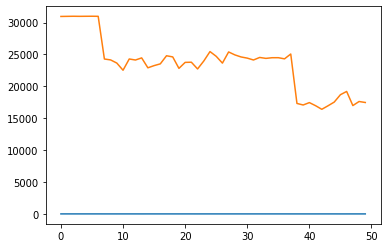

In [123]:
plt.plot(Data.test[1][0:50,0])
plt.plot(lstm_predicted[0:50])
plt.show()

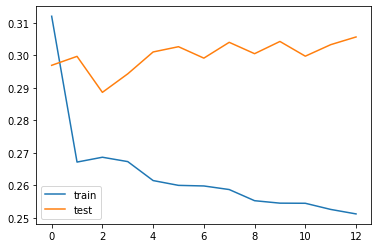

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

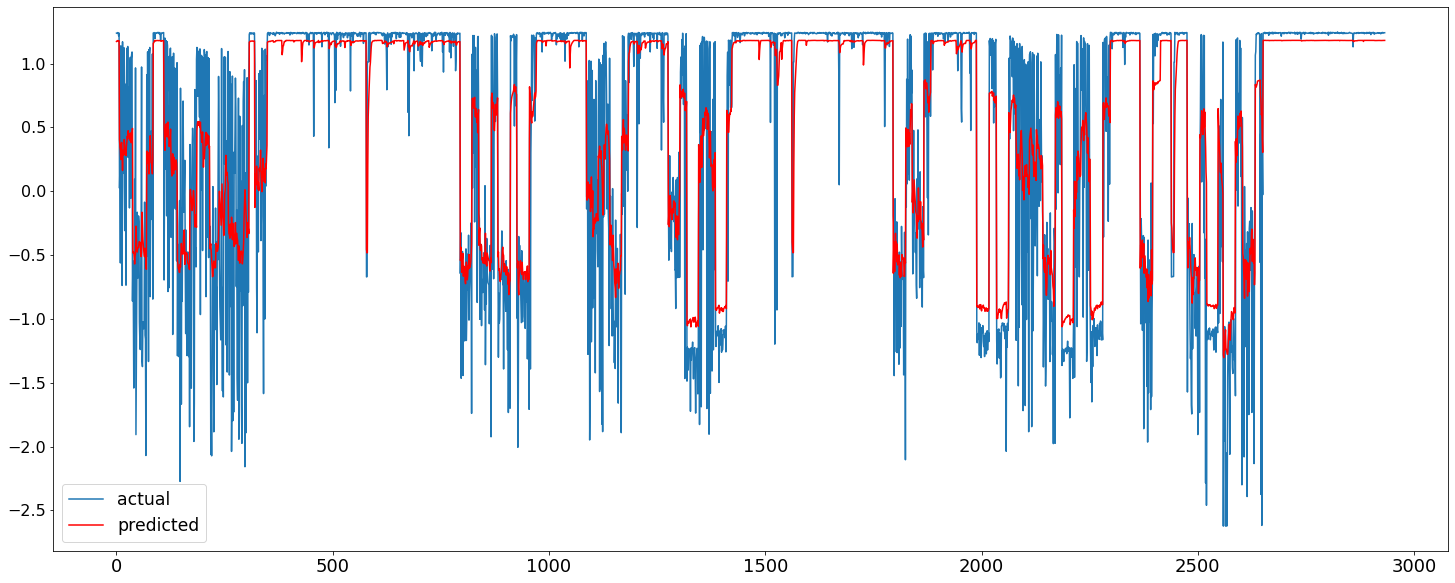

In [37]:
plt.figure(figsize=(25, 10))
plt.plot(Data.test[1][:,0],label="actual")
plt.plot(lstm_predicted, color='r',label="predicted")
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(Data.test[1][:,0], lstm_predicted)
rmse = sqrt(mean_squared_error(Data.test[1][:,0], lstm_predicted))
mae = mean_absolute_error(Data.test[1][:,0], lstm_predicted)
rse_val = rse(Data.test[1][:,0], lstm_predicted)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')

accuracy_stats['rmse']['lstm'] = rmse
accuracy_stats['rse']['lstm'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['lstm'] = mae
accuracy_stats['predicted']['lstm'] = lstm_predicted
accuracy_stats['mse']['lstm'] = mse

MSE: 0.2328726351261139
RMSE: 0.48256878797339753
MAE: 0.2861758768558502
RSE: 0.4890475869178772


In [39]:
lstm_predicted.shape

(2933,)

In [40]:
Data.test[1][:,0].shape

(2933,)

## Simple GRU

Do the same thing but with a GRU


In [41]:
ts_inputs = tf.keras.Input(shape=(10,3))
x = tf.keras.layers.GRU(units=1000, dropout=0.1, recurrent_dropout=0.5)(ts_inputs)
# x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1,activation='linear')(x)
gru_model = tf.keras.Model(inputs=ts_inputs, outputs=outputs)

In [42]:
gru_model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [43]:
gru_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 3)]           0         
_________________________________________________________________
gru (GRU)                    (None, 1000)              3015000   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1001      
Total params: 3,016,001
Trainable params: 3,016,001
Non-trainable params: 0
_________________________________________________________________


In [44]:
gru_model.fit(Data.train[0][:,:,:], Data.train[1][:,0], 
               epochs=100, 
               validation_data=(Data.valid[0][:,:,:], Data.valid[1][:,0]), 
               callbacks=[early_stopping],
               shuffle=True)

Epoch 1/100
363/363 [==============================] - 82s 226ms/step - loss: 0.2892 - tf_rse: 0.5634 - tf_corr: 0.8296 - mean_absolute_error: 0.3746 - mean_squared_error: 0.2892 - root_mean_squared_error: 0.5378 - val_loss: 0.2896 - val_tf_rse: 0.9059 - val_tf_corr: 0.6452 - val_mean_absolute_error: 0.3703 - val_mean_squared_error: 0.2896 - val_root_mean_squared_error: 0.5381
Epoch 2/100
363/363 [==============================] - 81s 222ms/step - loss: 0.2678 - tf_rse: 0.5400 - tf_corr: 0.8451 - mean_absolute_error: 0.3543 - mean_squared_error: 0.2678 - root_mean_squared_error: 0.5175 - val_loss: 0.2963 - val_tf_rse: 0.9752 - val_tf_corr: 0.6443 - val_mean_absolute_error: 0.3671 - val_mean_squared_error: 0.2963 - val_root_mean_squared_error: 0.5443
Epoch 3/100
363/363 [==============================] - 80s 221ms/step - loss: 0.2637 - tf_rse: 0.5366 - tf_corr: 0.8455 - mean_absolute_error: 0.3481 - mean_squared_error: 0.2637 - root_mean_squared_error: 0.5135 - val_loss: 0.2868 - val_tf

In [45]:
gru_model.evaluate(Data.test[0][:,:,:], Data.test[1][:,0])

92/92 [==============================] - 4s 46ms/step - loss: 0.2223 - tf_rse: 1.1890 - tf_corr: 0.3848 - mean_absolute_error: 0.2461 - mean_squared_error: 0.2223 - root_mean_squared_error: 0.4715


[0.22229759395122528,
 1.1889634132385254,
 0.38477015495300293,
 0.24609112739562988,
 0.22229759395122528,
 0.4714844524860382]

In [46]:
gru_predicted = gru_model.predict(Data.test[0][:,:,:]).flatten()

np.save('predicted_results/gru_32_predicted.npy', gru_predicted)
np.savetxt('predicted_results/gru_32_predicted.txt', gru_predicted)

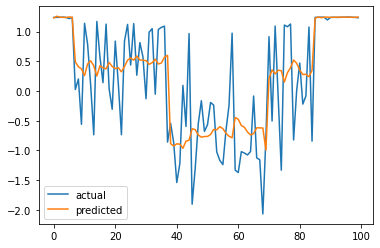

In [47]:
plt.plot(Data.test[1][0:100,0], label='actual')
plt.plot(gru_predicted[0:100], label="predicted")
plt.legend(loc='best')
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(Data.test[1][:,0], gru_predicted)
rmse = sqrt(mean_squared_error(Data.test[1][:,0], gru_predicted))
mae = mean_absolute_error(Data.test[1][:,0], gru_predicted)
rse_val = rse(Data.test[1][:,0], gru_predicted)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')

accuracy_stats['rmse']['gru'] = rmse
accuracy_stats['rse']['gru'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['gru'] = mae
accuracy_stats['predicted']['gru'] = gru_predicted
accuracy_stats['mse']['gru'] = mse

MSE: 0.22229760885238647
RMSE: 0.47148447360691154
MAE: 0.2460911124944687
RSE: 0.4778144657611847


### CNN MODEL

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D


# cnn_model = Sequential()
# cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(10, 3)))
# cnn_model.add(MaxPooling1D(pool_size=2))
# cnn_model.add(Flatten())
# cnn_model.add(Dense(50, activation='relu'))
# cnn_model.add(Dense(1))
# cnn_model.compile(optimizer='adam', loss='mse')

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=30, kernel_size=5, activation='relu', padding='SAME', strides=1, input_shape=(10, 3)))
cnn_model.add(MaxPooling1D(pool_size=2, strides=2))
cnn_model.add(Conv1D(filters=45, kernel_size=5, activation='relu', padding='SAME', strides=1))
cnn_model.add(MaxPooling1D(pool_size=2, strides=2))
cnn_model.add(Conv1D(filters=60, kernel_size=5, activation='relu', padding='SAME', strides=1))
cnn_model.add(MaxPooling1D(pool_size=2, strides=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(120, activation='relu'))
cnn_model.add(Dense(1))
# cnn_model.compile(optimizer='adam', loss='mse')

In [50]:
cnn_model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [51]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 30)            480       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 30)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 45)             6795      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 45)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 60)             13560     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 60)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 60)               

In [52]:
cnn_model.fit(Data.train[0][:,:,:], Data.train[1][:,0], 
               epochs=100, 
               validation_data=(Data.valid[0][:,:,:], Data.valid[1][:,0]), 
               callbacks=[early_stopping],
               shuffle=True)

Epoch 1/100
363/363 [==============================] - 1s 3ms/step - loss: 0.2759 - tf_rse: 0.5466 - tf_corr: 0.8437 - mean_absolute_error: 0.3515 - mean_squared_error: 0.2759 - root_mean_squared_error: 0.5252 - val_loss: 0.2995 - val_tf_rse: 0.7443 - val_tf_corr: 0.6448 - val_mean_absolute_error: 0.3686 - val_mean_squared_error: 0.2995 - val_root_mean_squared_error: 0.5473
Epoch 2/100
363/363 [==============================] - 1s 3ms/step - loss: 0.2508 - tf_rse: 0.5248 - tf_corr: 0.8527 - mean_absolute_error: 0.3298 - mean_squared_error: 0.2508 - root_mean_squared_error: 0.5008 - val_loss: 0.2941 - val_tf_rse: 1.4652 - val_tf_corr: 0.6483 - val_mean_absolute_error: 0.4011 - val_mean_squared_error: 0.2941 - val_root_mean_squared_error: 0.5423
Epoch 3/100
363/363 [==============================] - 1s 3ms/step - loss: 0.2466 - tf_rse: 0.5199 - tf_corr: 0.8564 - mean_absolute_error: 0.3264 - mean_squared_error: 0.2466 - root_mean_squared_error: 0.4966 - val_loss: 0.2839 - val_tf_rse: 0.8

In [53]:
cnn_stats = cnn_model.evaluate(Data.test[0][:,:,:], Data.test[1][:,0])
cnn_stats

92/92 [==============================] - 0s 2ms/step - loss: 0.2380 - tf_rse: 5.4381 - tf_corr: 0.3724 - mean_absolute_error: 0.2990 - mean_squared_error: 0.2380 - root_mean_squared_error: 0.4878


[0.23799726366996765,
 5.438087463378906,
 0.3724041283130646,
 0.2990496754646301,
 0.23799726366996765,
 0.487849622964859]

In [54]:
cnn_predicted = cnn_model.predict(Data.test[0][:,:,:]).flatten()

np.save('predicted_results/cnn_32_predicted.npy', cnn_predicted)
np.savetxt('predicted_results/cnn_32_predicted.txt', cnn_predicted)

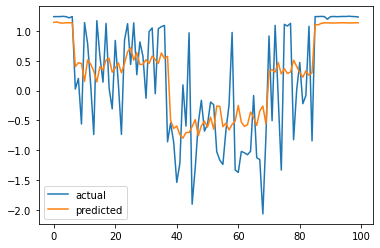

In [55]:
plt.plot(Data.test[1][0:100,0], label='actual')
plt.plot(cnn_predicted[0:100], label="predicted")
plt.legend(loc='best')
plt.show()

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(Data.test[1][:,0], cnn_predicted)
rmse = sqrt(mean_squared_error(Data.test[1][:,0], cnn_predicted))
mae = mean_absolute_error(Data.test[1][:,0], cnn_predicted)
rse_val = rse(Data.test[1][:,0], cnn_predicted)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')

accuracy_stats['rmse']['cnn'] = rmse
accuracy_stats['rse']['cnn'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['cnn'] = mae
accuracy_stats['predicted']['cnn'] = cnn_predicted
accuracy_stats['mse']['cnn'] = mse

MSE: 0.23799723386764526
RMSE: 0.4878496016885176
MAE: 0.2990497052669525
RSE: 0.4943992793560028


### CNN-LSTM HYBRID MODEL

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D

In [58]:
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='SAME', strides=1, input_shape=(10, 3)))
cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='SAME', strides=1))
cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))
# cnn_lstm_model.add(Conv1D(filters=10, kernel_size=3, activation='relu', padding='SAME', strides=1))
# cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))
# cnn_model.add(Flatten())
cnn_lstm_model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=False))
cnn_lstm_model.add(Dense(100, activation='relu'))
cnn_lstm_model.add(Dense(1))

In [59]:
cnn_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                       optimizer=tf.optimizers.Adam(),
                       metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [60]:
cnn_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 10, 64)            1024      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 5, 64)             12352     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               3300      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [61]:
cnn_lstm_model.fit(Data.train[0][:,:,:], Data.train[1][:,0], 
                   epochs=100, 
                   validation_data=(Data.valid[0][:,:,:], Data.valid[1][:,0]), 
                   callbacks=[early_stopping],
                   shuffle=True)

Epoch 1/100
363/363 [==============================] - 2s 5ms/step - loss: 0.2882 - tf_rse: 0.5598 - tf_corr: 0.8374 - mean_absolute_error: 0.3695 - mean_squared_error: 0.2882 - root_mean_squared_error: 0.5368 - val_loss: 0.3017 - val_tf_rse: 0.8147 - val_tf_corr: 0.6393 - val_mean_absolute_error: 0.3775 - val_mean_squared_error: 0.3017 - val_root_mean_squared_error: 0.5493
Epoch 2/100
363/363 [==============================] - 2s 5ms/step - loss: 0.2551 - tf_rse: 0.5300 - tf_corr: 0.8499 - mean_absolute_error: 0.3368 - mean_squared_error: 0.2551 - root_mean_squared_error: 0.5051 - val_loss: 0.3259 - val_tf_rse: 1.5709 - val_tf_corr: 0.6425 - val_mean_absolute_error: 0.3904 - val_mean_squared_error: 0.3259 - val_root_mean_squared_error: 0.5708
Epoch 3/100
363/363 [==============================] - 2s 5ms/step - loss: 0.2483 - tf_rse: 0.5238 - tf_corr: 0.8552 - mean_absolute_error: 0.3286 - mean_squared_error: 0.2483 - root_mean_squared_error: 0.4983 - val_loss: 0.2899 - val_tf_rse: 0.9

In [62]:
cnn_lstm1_stats = cnn_lstm_model.evaluate(Data.test[0][:,:,:], Data.test[1][:,0])
cnn_lstm1_stats

92/92 [==============================] - 0s 1ms/step - loss: 0.2283 - tf_rse: 2.0828 - tf_corr: 0.3724 - mean_absolute_error: 0.2595 - mean_squared_error: 0.2283 - root_mean_squared_error: 0.4778


[0.22827431559562683,
 2.0828425884246826,
 0.3724125623703003,
 0.25948870182037354,
 0.22827431559562683,
 0.47778061032295227]

In [63]:
cnn_lstm_predicted = cnn_lstm_model.predict(Data.test[0][:,:,:]).flatten()

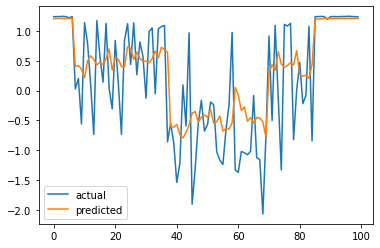

In [64]:
plt.plot(Data.test[1][0:100,0], label='actual')
plt.plot(cnn_lstm_predicted[0:100], label="predicted")
plt.legend(loc='best')
plt.show()

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(Data.test[1][:,0], cnn_lstm_predicted)
rmse = sqrt(mean_squared_error(Data.test[1][:,0], cnn_lstm_predicted))
mae = mean_absolute_error(Data.test[1][:,0], cnn_lstm_predicted)
rse_val = rse(Data.test[1][:,0], cnn_lstm_predicted)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')

accuracy_stats['rmse']['cnn_lstm'] = rmse
accuracy_stats['rse']['cnn_lstm'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['cnn_lstm'] = mae
accuracy_stats['predicted']['cnn_lstm'] = cnn_lstm_predicted
accuracy_stats['mse']['cnn_lstm'] = mse

MSE: 0.22827421128749847
RMSE: 0.4777805053447644
MAE: 0.25948870182037354
RSE: 0.4841949939727783


### Take 2

In [66]:
Data.train[0].shape

(11587, 10, 3)

In [67]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10,
                                                mode='min')

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, LSTM, MaxPooling2D, Reshape, TimeDistributed, Input, Dropout, GRU

In [69]:
X = Input(shape = (10,3))


#CNN
C = Reshape((10, 3, 1))(X)

# Apply a Conv2D that will transform it into data of dimensions (batchsize, time, 1, NumofFilters)
C = Conv2D(filters=200, kernel_size=(1, 3), kernel_initializer='glorot_uniform')(C)
C = Dropout(0.2)(C)

# Adjust data dimensions by removing axis=2 which is always equal to 1
c_shape = K.int_shape(C)
C = Reshape((c_shape[1], c_shape[3]))(C)

# Apply a GRU layer (with activation set to 'relu' as per the paper) and take the returned states as result
_, R = GRU(200, activation="relu", return_sequences = False, return_state = True)(C)
R    = Dropout(0.2)(R)
Y = Flatten()(R)
Y = Dense(3)(Y)
cnn_lstm_model2 = Model(inputs = X, outputs = Y)

In [70]:
cnn_lstm_model2.compile(loss=tf.losses.MeanSquaredError(),
                       optimizer=tf.optimizers.Adam(),
                       metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [71]:
cnn_lstm_model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10, 3)]           0         
_________________________________________________________________
reshape (Reshape)            (None, 10, 3, 1)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 1, 200)        800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 1, 200)        0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 10, 200)           0         
_________________________________________________________________
gru_1 (GRU)                  [(None, 200), (None, 200) 241200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0   

In [72]:
# tf.random.set_seed(123456)
cnn_lstm_model2.fit(Data.train[0][:,:,:], Data.train[1][:,0], 
                   epochs=10, 
                   validation_data=(Data.valid[0][:,:,:], Data.valid[1]), 
                   callbacks=[early_stopping],
                   shuffle=True)

Epoch 1/10
363/363 [==============================] - 5s 15ms/step - loss: 0.2705 - tf_rse: 0.5412 - tf_corr: 0.8428 - mean_absolute_error: 0.3530 - mean_squared_error: 0.2705 - root_mean_squared_error: 0.5201 - val_loss: 1.2065 - val_tf_rse: 1.3200 - val_tf_corr: nan - val_mean_absolute_error: 0.8178 - val_mean_squared_error: 1.2065 - val_root_mean_squared_error: 1.0984
Epoch 2/10
363/363 [==============================] - 5s 14ms/step - loss: 0.2550 - tf_rse: 0.5266 - tf_corr: 0.8510 - mean_absolute_error: 0.3377 - mean_squared_error: 0.2550 - root_mean_squared_error: 0.5050 - val_loss: 1.2253 - val_tf_rse: 1.3352 - val_tf_corr: nan - val_mean_absolute_error: 0.8333 - val_mean_squared_error: 1.2253 - val_root_mean_squared_error: 1.1069
Epoch 3/10
363/363 [==============================] - 5s 14ms/step - loss: 0.2504 - tf_rse: 0.5237 - tf_corr: 0.8526 - mean_absolute_error: 0.3324 - mean_squared_error: 0.2504 - root_mean_squared_error: 0.5004 - val_loss: 1.1363 - val_tf_rse: 1.2823 - 

In [73]:
cnn_lstm_model2.evaluate(Data.test[0][:,:,:], Data.test[1])

92/92 [==============================] - 0s 5ms/step - loss: 1.8886 - tf_rse: 1.4443 - tf_corr: nan - mean_absolute_error: 1.0652 - mean_squared_error: 1.8886 - root_mean_squared_error: 1.3743


[1.8885964155197144,
 1.4442780017852783,
 nan,
 1.0652114152908325,
 1.8885964155197144,
 1.3742622137069702]

In [74]:
cnn_lstm_model2_predicted = cnn_lstm_model.predict(Data.test[0][:,:,:])

np.save('predicted_results/cnn_lstm_32_predicted.npy', cnn_lstm_model2_predicted)
np.savetxt('predicted_results/cnn_lstm_32_predicted.txt', cnn_lstm_model2_predicted)

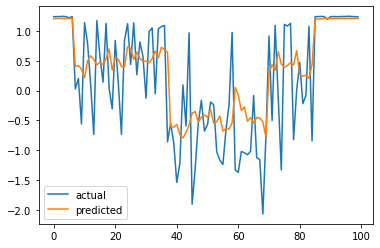

In [75]:
plt.plot(Data.test[1][0:100,0], label='actual')
plt.plot(cnn_lstm_model2_predicted[0:100,0], label="predicted")
plt.legend(loc='best')
plt.show()

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(Data.test[1][:,0], cnn_lstm_model2_predicted.flatten())
rmse = sqrt(mean_squared_error(Data.test[1][:,0], cnn_lstm_model2_predicted.flatten()))
mae = mean_absolute_error(Data.test[1][:,0], cnn_lstm_model2_predicted.flatten())
rse_val = rse(Data.test[1][:,0], cnn_lstm_model2_predicted[:,0].flatten())

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')

accuracy_stats['rmse']['cnn_lstm2'] = rmse
accuracy_stats['rse']['cnn_lstm2'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['cnn_lstm2'] = mae
accuracy_stats['predicted']['cnn_lstm2'] = cnn_lstm_model2_predicted
accuracy_stats['mse']['cnn_lstm2'] = mse

MSE: 0.22827421128749847
RMSE: 0.4777805053447644
MAE: 0.25948870182037354
RSE: 0.4841949939727783


### LSTNET MODEL

In [131]:
from tensorflow.keras.models import Model, model_from_json

custom_objects = {
        'PreSkipTrans': PreSkipTrans,
        'PostSkipTrans': PostSkipTrans,
        'PreARTrans': PreARTrans,
        'PostARTrans': PostARTrans
        }


def custom_loss(y_true, y_pred):
    # print("CUSTOM LOSS BABBBY")
    # print(type(y_true))
    # print(type(y_pred))
    # print(y_true)
    # print(y_true.shape)
    # tf.print(y_true[:,0, sys.stdout)
    return tf.keras.losses.mean_absolute_error(y_true[:,0], y_pred[:,0])

file = 'models/model_multithread_4.json'
model = None
with open(file, "r") as json_file:
  model = model_from_json(json_file.read(), custom_objects=custom_objects)


In [132]:
model.compile(loss=custom_loss,
                       optimizer=tf.optimizers.Adam(),
                       metrics=[single_rse, single_corr, tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [133]:
model.fit(Data.train[0][:,:,:], Data.train[1][:,0], 
                   epochs=20, 
                   validation_data=(Data.valid[0][:,:,:], Data.valid[1][:,0]), 
                   callbacks=[early_stopping],
                   shuffle=True,
                   batch_size=91)

Epoch 1/20
128/128 [==============================] - 4s 34ms/step - loss: 0.3505 - single_rse: 0.5890 - single_corr: 0.8192 - tf_rse: 1.3850 - tf_corr: 0.3359 - mean_absolute_error: 0.9088 - mean_squared_error: 1.7366 - root_mean_squared_error: 1.3178 - val_loss: 0.3702 - val_single_rse: 0.6570 - val_single_corr: 0.7651 - val_tf_rse: 2.0076 - val_tf_corr: 0.3837 - val_mean_absolute_error: 0.9842 - val_mean_squared_error: 1.8379 - val_root_mean_squared_error: 1.3557
Epoch 2/20
128/128 [==============================] - 3s 25ms/step - loss: 0.3215 - single_rse: 0.5528 - single_corr: 0.8371 - tf_rse: 1.3546 - tf_corr: 0.3461 - mean_absolute_error: 0.8813 - mean_squared_error: 1.6596 - root_mean_squared_error: 1.2882 - val_loss: 0.3558 - val_single_rse: 0.6379 - val_single_corr: 0.7717 - val_tf_rse: 1.9751 - val_tf_corr: 0.3596 - val_mean_absolute_error: 0.9617 - val_mean_squared_error: 1.7624 - val_root_mean_squared_error: 1.3275
Epoch 3/20
120/128 [===========================>..] - ETA:

KeyboardInterrupt: 

In [ ]:
model.summary()

In [ ]:
model.evaluate(Data.test[0], Data.test[1])

In [ ]:
predicted = model.predict(Data.test[0])

np.save('predicted_results/lstnet_32_predicted.npy', predicted)
np.savetxt('predicted_results/lstnet_32_predicted.txt', predicted)

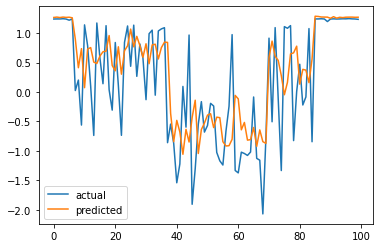

In [33]:
plt.plot(Data.test[1][0:100,0], label='actual')
plt.plot(predicted[0:100, 0], label="predicted")
plt.legend(loc='best')
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
print(f'MSE: {mean_squared_error(Data.test[1][:,0], predicted[:,0])}')
print(f'RMSE: {sqrt(mean_squared_error(Data.test[1][:,0], predicted[:,0]))}')
print(f'MAE: {mean_absolute_error(Data.test[1][:,0], predicted[:,0])}')
print(f'RSE: {rse(Data.test[1][:,0], predicted[:,0])}')

MSE: 0.26221707463264465
RMSE: 0.5120713569734638
MAE: 0.2646794617176056
RSE: 0.5189441442489624


In [35]:
Data.test[1][:,0]

array([1.2386438, 1.2398742, 1.2398742, ..., 1.2412279, 1.241474 ,
       1.2422123], dtype=float32)

In [36]:
predicted[:,0]

array([1.2653428, 1.2713275, 1.2639613, ..., 1.271269 , 1.2728636,
       1.2710875], dtype=float32)

In [37]:
# print(f'RMSE: {sqrt(Data.test[1][:,0], predicted[:,0]))}')

In [38]:
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100

In [39]:
mean_absolute_percentage_error(Data.test[1][:,0]*Data.normalize_std[1] + Data.normalize_mean[1], predicted[:,0]*Data.normalize_std[1] + Data.normalize_mean[1])

206.01155757904053

# Comparison between Different Methods

In [134]:
mlp_predicted = np.load('predicted_results/mlp_32_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
lstm_predicted = np.load('predicted_results/lstm_32_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
gru_predicted = np.load('predicted_results/gru_32_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
cnn_predicted = np.load('predicted_results/cnn_32_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
cnn_lstm_predicted = np.load('predicted_results/cnn_lstm_32_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
lstnet_predicted = np.load('predicted_results/lstnet_32_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]

data_true = Data.test[1][:,0]*Data.normalize_std[0] + Data.normalize_mean[0]

In [135]:
data_true

array([31471., 31481., 31481., ..., 31492., 31494., 31500.], dtype=float32)

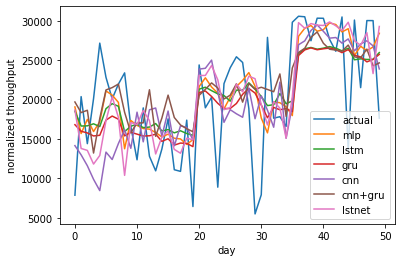

In [136]:
start_time = 150
end_time = 200

plt.plot(data_true[start_time:end_time], label='actual')
plt.plot(mlp_predicted[start_time:end_time, 0], label="mlp")
plt.plot(lstm_predicted[start_time:end_time], label="lstm")
plt.plot(gru_predicted[start_time:end_time], label="gru")
plt.plot(cnn_predicted[start_time:end_time], label="cnn")
plt.plot(cnn_lstm_predicted[start_time:end_time, 0], label="cnn+gru")
plt.plot(lstnet_predicted[start_time:end_time, 0], label="lstnet")
plt.ylabel('normalized throughput')
plt.xlabel('day')
plt.legend(loc='best')
plt.show()

### RMSE

In [137]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [138]:
mlp_rmse = sqrt(mean_squared_error(data_true, mlp_predicted[:, 0]))
mlp_rmse

4060.322400992315

In [139]:
lstm_rmse = sqrt(mean_squared_error(data_true, lstm_predicted))
lstm_rmse

3844.4164706753613

In [140]:
gru_rmse = sqrt(mean_squared_error(data_true, gru_predicted))
gru_rmse

3833.160575817298

In [141]:
cnn_rmse = sqrt(mean_squared_error(data_true, cnn_predicted))
cnn_rmse

4079.812863355377

In [142]:
cnn_lstm_rmse = sqrt(mean_squared_error(data_true, cnn_lstm_predicted[:, 0]))
cnn_lstm_rmse

4028.14994755657

In [143]:
lstnet_rmse = sqrt(mean_squared_error(data_true, lstnet_predicted[:, 0]))
lstnet_rmse

4161.351703473284

Text(0, 0.5, 'Root Mean Squared Error (RMSE)')

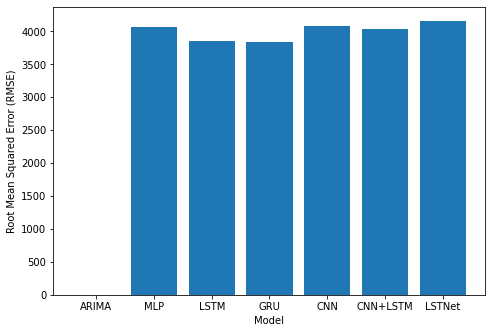

In [144]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[0.45, mlp_rmse, lstm_rmse, gru_rmse, cnn_rmse, cnn_lstm_rmse, lstnet_rmse])
ax.set_xlabel('Model')

ax.set_ylabel('Root Mean Squared Error (RMSE)')

### MAPE

In [145]:
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100

In [146]:
mlp_mape = mean_absolute_percentage_error(data_true, mlp_predicted[:, 0])
mlp_mape

30.329737067222595

In [147]:
lstm_mape = mean_absolute_percentage_error(data_true, lstm_predicted)
lstm_mape

32.53453075885773

In [148]:
gru_mape = mean_absolute_percentage_error(data_true, gru_predicted)
gru_mape

30.538564920425415

In [149]:
cnn_mape = mean_absolute_percentage_error(data_true, cnn_predicted)
cnn_mape

30.737140774726868

In [150]:
cnn_lstm_mape = mean_absolute_percentage_error(data_true, cnn_lstm_predicted[:, 0])
cnn_lstm_mape

35.07172167301178

In [151]:
lstnet_mape = mean_absolute_percentage_error(data_true, lstnet_predicted[:, 0])
lstnet_mape

29.3034166097641

Text(0, 0.5, 'Mean Absolute Percentage Error (MAPE) %')

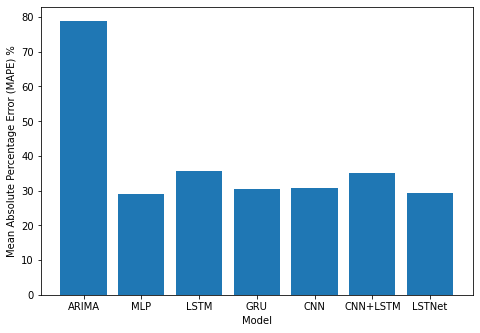

In [58]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[79, mlp_mape, lstm_mape, gru_mape, cnn_mape, cnn_lstm_mape, lstnet_mape])
ax.set_xlabel('Model')
# ax.set_ylim(0.0, 0.9)
ax.set_ylabel('Mean Absolute Percentage Error (MAPE) %')

### CORR

In [154]:
mlp_corr = corr(data_true, mlp_predicted[:, 0])
mlp_corr

0.862791

In [155]:
lstm_corr = corr(data_true, lstm_predicted)
lstm_corr

0.87802404

In [156]:
gru_corr = corr(data_true, gru_predicted)
gru_corr

0.87921375

In [157]:
cnn_corr = corr(data_true, cnn_predicted)
cnn_corr

0.8635657

In [158]:
cnn_lstm_corr = corr(data_true, cnn_lstm_predicted[:, 0])
cnn_lstm_corr

0.86527795

In [65]:
lstnet_corr = corr(data_true, lstnet_predicted[:, 0])
lstnet_corr

0.8603661

Text(0, 0.5, 'Mean Absolute Percentage Error (MAPE) %')

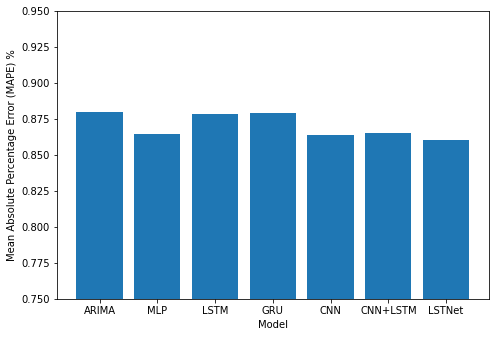

In [66]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[0.88, mlp_corr, lstm_corr, gru_corr, cnn_corr, cnn_lstm_corr, lstnet_corr])
ax.set_xlabel('Model')
ax.set_ylim(0.75, 0.95)
ax.set_ylabel('Mean Absolute Percentage Error (MAPE) %')

### MAE

In [143]:
from sklearn.metrics import mean_absolute_error

In [144]:
mlp_mae = mean_absolute_error(data_true, mlp_predicted[:, 0])
mlp_mae

2258.941

In [145]:
lstm_mae = mean_absolute_error(data_true, lstm_predicted)
lstm_mae

2325.556

In [146]:
gru_mae = mean_absolute_error(data_true, gru_predicted)
gru_mae

1999.8148

In [147]:
cnn_mae = mean_absolute_error(data_true, cnn_predicted)
cnn_mae

2430.1729

In [148]:
cnn_lstm_mae = mean_absolute_error(data_true, cnn_lstm_predicted[:, 0])
cnn_lstm_mae

2108.6873

In [149]:
lstnet_mae = mean_absolute_error(data_true, lstnet_predicted[:, 0])
lstnet_mae

2660.772

Text(0, 0.5, 'Mean Absolute Percentage Error (MAPE) %')

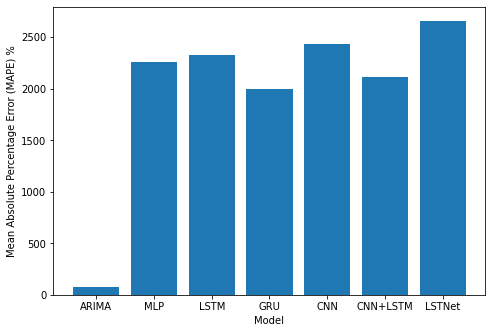

In [150]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[79, mlp_mae, lstm_mae, gru_mae, cnn_mae, cnn_lstm_mae, lstnet_mae])
ax.set_xlabel('Model')
# ax.set_ylim(0.0, 0.9)
ax.set_ylabel('Mean Absolute Percentage Error (MAPE) %')

### RRSE

In [151]:
mlp_rrse = rse(data_true, mlp_predicted[:, 0])
mlp_rrse

0.50299627

In [152]:
lstm_rrse = rse(data_true, lstm_predicted)
lstm_rrse

0.48904762

In [153]:
gru_rrse = rse(data_true, gru_predicted)
gru_rrse

0.47781453

In [154]:
cnn_rrse = rse(data_true, cnn_predicted)
cnn_rrse

0.49439934

In [155]:
cnn_lstm_rrse = rse(data_true, cnn_lstm_predicted[:, 0].flatten())
cnn_lstm_rrse

0.48419502

In [156]:
lstnet_rrse = rse(data_true, lstnet_predicted[:, 0].flatten())
lstnet_rrse

0.53964454

Text(0, 0.5, 'Root Relative Squared Error (RRSE)')

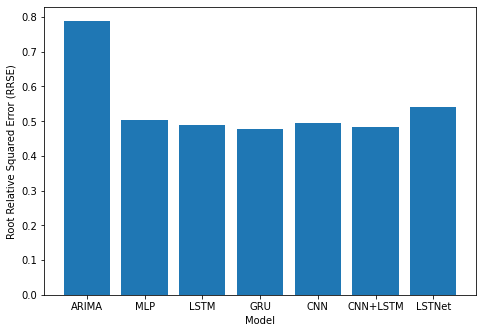

In [157]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[0.79, mlp_rrse,lstm_rrse,gru_rrse,cnn_rrse,cnn_lstm_rrse,lstnet_rrse])
ax.set_xlabel('Model')
# ax.set_ylim(0.0, 0.9)
ax.set_ylabel('Root Relative Squared Error (RRSE)')